TEST 1: Basic CVaR with Uniform Probabilities

Scenario Statistics:
  Mean earnings: 48.96
  Std earnings: 9.04
  Min earnings: 23.80
  Max earnings: 68.52

CVaR Calculations (alpha=0.95):
  Left-tail CVaR (worst 5%): 29.51
  Right-tail CVaR (best 5%): 29.51
  Manual left CVaR (simple average): 30.05


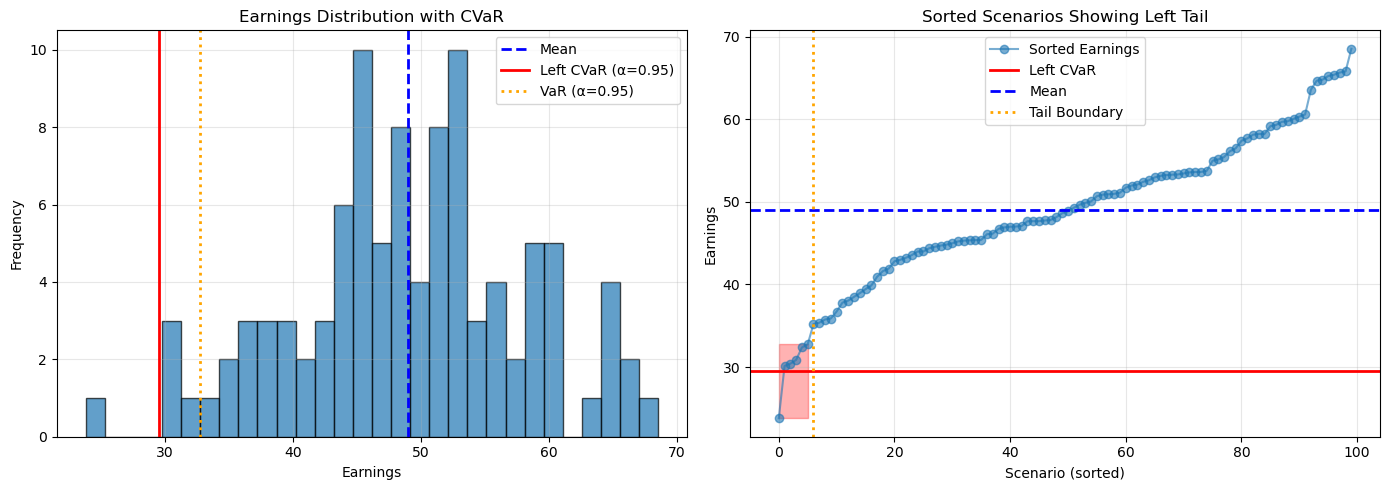

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# CVaR Implementation Functions (from your utils.py)
# ============================================================================


def get_worst_case_mask(z, probabilities, alpha=0.95):
    """
    Identify scenarios in the worst (1-alpha)% tail of z.
    
    Parameters:
    -----------
    z : array-like
        Values to determine worst cases (e.g., z = x * y)
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level (e.g., 0.95 means worst 5%)
    
    Returns:
    --------
    mask : boolean array
        True for scenarios in the worst tail
    """
    z = np.asarray(z, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()  # Normalize
    
    tail_mass = 1.0 - alpha  # Probability mass in the tail
    
    # Sort by z values (worst to best)
    order = np.argsort(z)
    probs_sorted = probs[order]
    
    # Cumulative probability
    cdf = np.cumsum(probs_sorted)
    
    # Find where cumulative probability reaches tail_mass
    boundary_idx = np.searchsorted(cdf, tail_mass, side='right')
    
    # Create mask for tail scenarios
    mask = np.zeros(len(z), dtype=bool)
    mask[order[:boundary_idx]] = True
    
    return mask


def conditional_cvar(x, z, probabilities, alpha=0.95):
    """
    Calculate CVaR of x conditional on z being in its worst tail.
    
    Parameters:
    -----------
    x : array-like
        Variable to calculate CVaR for
    z : array-like
        Variable that determines worst-case scenarios (e.g., z = x * y)
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level
    
    Returns:
    --------
    float : Conditional CVaR of x given z is in worst tail
    """
    x = np.asarray(x, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    # Get worst-case scenarios based on z
    tail_mask = get_worst_case_mask(z, probs, alpha)
    
    # Extract x values and probabilities for tail scenarios
    x_tail = x[tail_mask]
    probs_tail = probs[tail_mask]
    
    # Calculate probability-weighted CVaR of x in the tail
    cvar_x = np.sum(x_tail * probs_tail) / np.sum(probs_tail)
    
    return cvar_x



def calculate_cvar_left_simple(earnings: np.ndarray, alpha: float) -> float:
    """
    Left-tail CVaR using simple percentile method (assuming uniform probabilities).
    Returns the conditional mean of the worst (1-alpha) tail.
    alpha is the confidence level (e.g. 0.95 -> worst 5% left tail).
    """
    earnings = np.array(earnings)
    earnings_sorted = np.sort(earnings)  # worst -> best
    tail_mass = 1.0 - alpha
    var_threshold = np.percentile(earnings_sorted, tail_mass * 100)
    left_tail = earnings_sorted[earnings_sorted <= var_threshold]
    cvar = np.mean(left_tail)
    return cvar


def calculate_cvar_left(earnings: np.ndarray, probabilities: np.ndarray, alpha: float) -> float:
    """
    Discrete left-CVaR (conditional mean of the worst tail mass).
    alpha is the confidence level (e.g. 0.95 -> worst 5% left tail).
    Returns conditional mean over the worst tail mass = tail_mass = 1-alpha.
    """
    values = np.asarray(earnings, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()

    tail_mass = 1.0 - float(alpha)
    if tail_mass <= 0:
        return np.nan

    order = np.argsort(values)           # worst -> best
    v = values[order]
    p = probs[order]
    cdf = np.cumsum(p)

    # index where cumulative >= tail_mass
    k = np.searchsorted(cdf, tail_mass, side='left')

    # probability strictly before k
    prob_before = cdf[k-1] if k > 0 else 0.0
    need = tail_mass - prob_before     # fraction of p[k] needed

    # sum full contributions for indices < k
    sum_full = (p[:k] * v[:k]).sum()
    # add fractional contribution from the k-th element if k is within bounds
    if k < len(v):
        sum_full += need * v[k]
    # conditional mean = weighted_sum / tail_mass
    cvar = sum_full / tail_mass
    return cvar


def _left_tail_mask(arr, probabilities, alpha):
    """
    Return boolean mask for scenarios in the left tail.
    """
    values = np.asarray(arr, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    tail_mass = 1.0 - float(alpha)

    order = np.argsort(values)           # worst -> best
    p_sorted = probs[order]
    cdf = np.cumsum(p_sorted)
    boundary_idx = np.searchsorted(cdf, tail_mass, side='left')

    mask = np.zeros_like(values, dtype=bool)
    if boundary_idx < len(order):
        mask[order[: boundary_idx + 1]] = True
    else:
        mask[order[: boundary_idx]] = True

    prob_before = cdf[boundary_idx - 1] if boundary_idx > 0 else 0.0
    need = max(0.0, tail_mass - prob_before) if boundary_idx < len(order) else 0.0

    return mask, order, boundary_idx, cdf, need


def _left_tail_weighted_sum(probabilities, values, order, boundary_idx, cdf, tail_mass):
    """
    Return the conditional mean over the left tail.
    """
    probs = np.asarray(probabilities, dtype=float).ravel()
    vals = np.asarray(values, dtype=float).ravel()
    probs = probs / probs.sum()

    if order is None:
        order = np.argsort(vals)
        probs_sorted = probs[order]
        cdf = np.cumsum(probs_sorted)
        boundary_idx = np.searchsorted(cdf, tail_mass, side='left')


    
    

    return calculate_cvar_left(vals, probs, alpha=(1.0 - tail_mass))


# ============================================================================
# TEST 1: Basic CVaR Calculation - Uniform Probabilities
# ============================================================================

print("="*80)
print("TEST 1: Basic CVaR with Uniform Probabilities")
print("="*80)

# Create simple test data
np.random.seed(42)
n_scenarios = 100
earnings = np.random.randn(n_scenarios) * 10 + 50  # Mean ~50, Std ~10
probs_uniform = np.ones(n_scenarios) / n_scenarios  # Equal probability

alpha = 0.95  # 95% confidence -> look at worst 5%

# Calculate CVaRs
cvar_left = calculate_cvar_left(earnings, probs_uniform, alpha)
cvar_right = calculate_cvar_left_simple(earnings, alpha)

print(f"\nScenario Statistics:")
print(f"  Mean earnings: {earnings.mean():.2f}")
print(f"  Std earnings: {earnings.std():.2f}")
print(f"  Min earnings: {earnings.min():.2f}")
print(f"  Max earnings: {earnings.max():.2f}")

print(f"\nCVaR Calculations (alpha={alpha}):")
print(f"  Left-tail CVaR (worst {(1-alpha)*100:.0f}%): {cvar_left:.2f}")
print(f"  Right-tail CVaR (best {(1-alpha)*100:.0f}%): {cvar_right:.2f}")

# Manual verification
tail_mass = 1 - alpha
n_tail = int(np.ceil(n_scenarios * tail_mass))
sorted_earnings = np.sort(earnings)
manual_left_cvar = sorted_earnings[:n_tail].mean()
print(f"  Manual left CVaR (simple average): {manual_left_cvar:.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Distribution with CVaR
axes[0].hist(earnings, bins=30, alpha=0.7, edgecolor='black')
axes[0].axvline(earnings.mean(), color='blue', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(cvar_left, color='red', linestyle='-', linewidth=2, label=f'Left CVaR (α={alpha})')
axes[0].axvline(np.percentile(earnings, (1-alpha)*100), color='orange', linestyle=':', 
                linewidth=2, label=f'VaR (α={alpha})')
axes[0].set_xlabel('Earnings')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Earnings Distribution with CVaR')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: Sorted earnings showing tail
sorted_idx = np.argsort(earnings)
axes[1].plot(range(n_scenarios), earnings[sorted_idx], 'o-', alpha=0.6, label='Sorted Earnings')
axes[1].axhline(cvar_left, color='red', linestyle='-', linewidth=2, label='Left CVaR')
axes[1].axhline(earnings.mean(), color='blue', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(n_tail, color='orange', linestyle=':', linewidth=2, label='Tail Boundary')
axes[1].fill_between(range(n_tail), earnings[sorted_idx[:n_tail]].min(), 
                      earnings[sorted_idx[:n_tail]].max(), alpha=0.3, color='red')
axes[1].set_xlabel('Scenario (sorted)')
axes[1].set_ylabel('Earnings')
axes[1].set_title('Sorted Scenarios Showing Left Tail')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TEST 2: Conditional Price Expectation Given Worst Revenue Scenarios

Data Statistics:
  Revenues - Mean: 8.03, Std: 0.81
  Prices - Mean: 49.99, Std: 5.02
  Correlation: 1.000
New Conditional CVaR of x (given z in worst 5%): 39.6188999

Number of scenarios in tail: 499
Probability mass in tail: 0.0499

CVaR Calculations:
  Direct CVaR of prices: 39.6231132
  Conditional E[Price | worst revenues]: 39.6231132
  Difference: 0.0000000

Worst 5% revenue scenarios: 500 scenarios
  Revenue range: [4.88, 6.70]
  Price range in worst revenue scenarios: [30.39, 41.73]


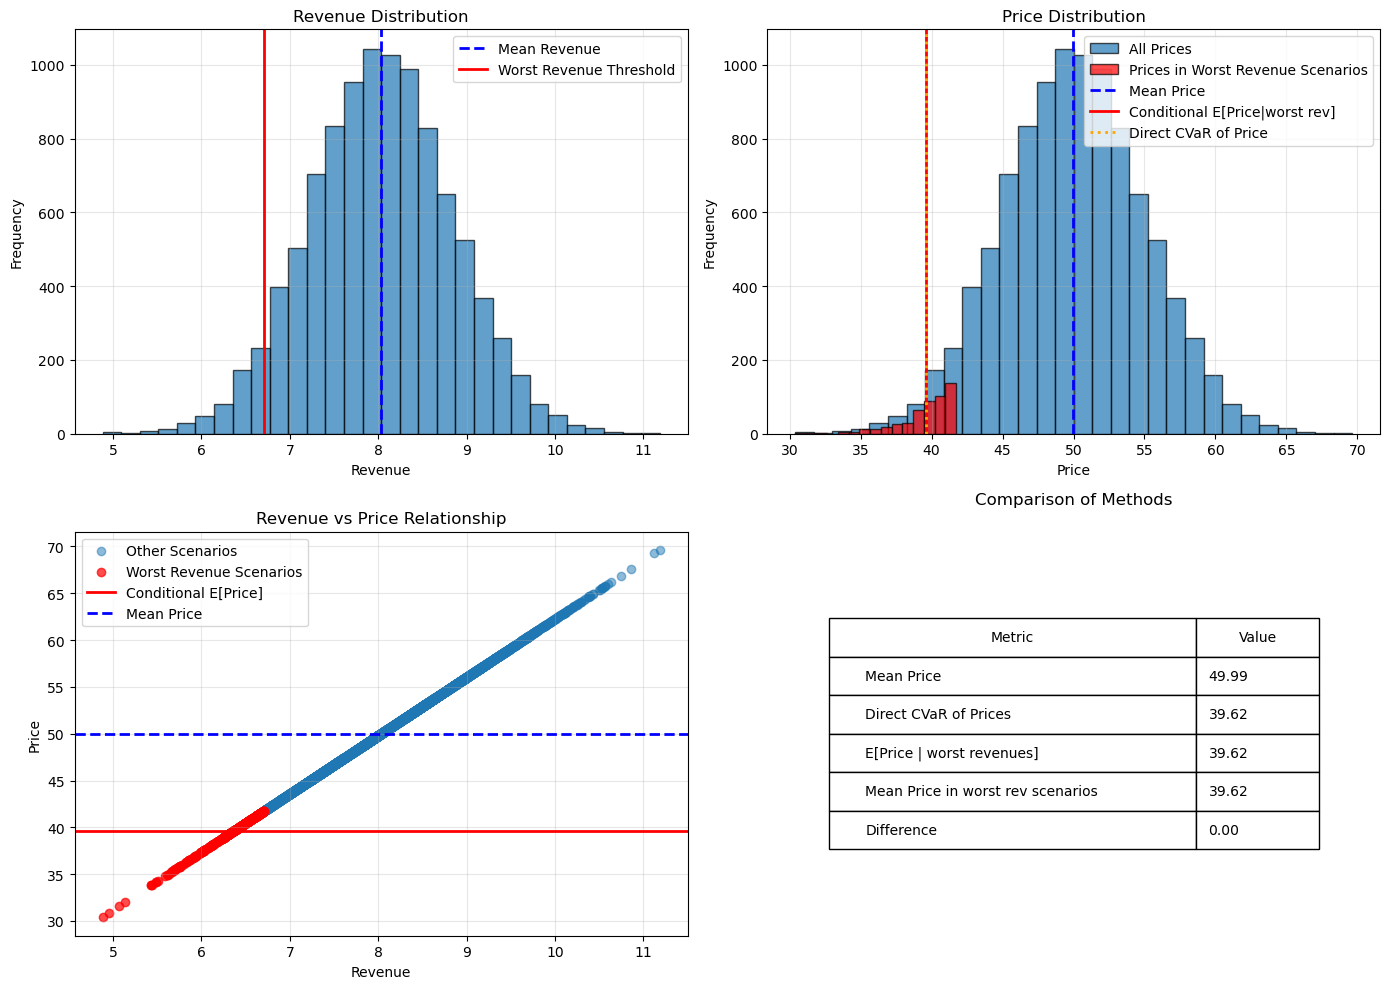

In [3]:
# ============================================================================
# TEST 2: Conditional Expectation - The Key Use Case
# ============================================================================

print("\n" + "="*80)
print("TEST 2: Conditional Price Expectation Given Worst Revenue Scenarios")
print("="*80)

# Simulate revenues and prices
n_scenarios = 10000
np.random.seed(42)

# Revenues (what we condition on)

# Prices (what we want to calculate expectation of)
# Make prices somewhat correlated with revenues (but not perfectly)
prices = 50 + np.random.randn(n_scenarios) * 5
production = 0.5 *  np.random.rand()
revenues = production * prices 


probs = np.ones(n_scenarios) / n_scenarios
alpha = 0.95

print(f"\nData Statistics:")
print(f"  Revenues - Mean: {revenues.mean():.2f}, Std: {revenues.std():.2f}")
print(f"  Prices - Mean: {prices.mean():.2f}, Std: {prices.std():.2f}")
print(f"  Correlation: {np.corrcoef(revenues, prices)[0,1]:.3f}")

# Method 1: Direct CVaR of prices (INCORRECT for your use case)
cvar_prices_direct = calculate_cvar_left(prices, probs, alpha)

# Method 2: Conditional expectation of prices given worst revenues (CORRECT)
mask, order, boundary_idx, cdf, need = _left_tail_mask(revenues, probs, alpha)
conditional_prices = _left_tail_weighted_sum(probs, prices, order, boundary_idx, cdf, 1-alpha)

# Method 3 new method: 

cvar_x_given_z_worst = conditional_cvar(prices, revenues, probs, alpha=alpha)

print(f"New Conditional CVaR of x (given z in worst {(1-alpha)*100:.0f}%): {cvar_x_given_z_worst:.7f}")

# Also show which scenarios are in the tail
tail_mask = get_worst_case_mask(revenues, probs, alpha=alpha)
print(f"\nNumber of scenarios in tail: {tail_mask.sum()}")
print(f"Probability mass in tail: {probs[tail_mask].sum():.4f}")

print(f"\nCVaR Calculations:")
print(f"  Direct CVaR of prices: {cvar_prices_direct:.7f}")
print(f"  Conditional E[Price | worst revenues]: {conditional_prices:.7f}")
print(f"  Difference: {abs(cvar_prices_direct - conditional_prices):.7f}")

# Show which scenarios are selected
worst_revenue_scenarios = np.where(mask)[0]
print(f"\nWorst {(1-alpha)*100:.0f}% revenue scenarios: {len(worst_revenue_scenarios)} scenarios")
print(f"  Revenue range: [{revenues[mask].min():.2f}, {revenues[mask].max():.2f}]")
print(f"  Price range in worst revenue scenarios: [{prices[mask].min():.2f}, {prices[mask].max():.2f}]")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Revenue distribution
axes[0,0].hist(revenues, bins=30, alpha=0.7, edgecolor='black')
axes[0,0].axvline(revenues.mean(), color='blue', linestyle='--', linewidth=2, label='Mean Revenue')
axes[0,0].axvline(revenues[mask].max(), color='red', linestyle='-', linewidth=2, 
                  label='Worst Revenue Threshold')
axes[0,0].set_xlabel('Revenue')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Revenue Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Top-right: Price distribution
axes[0,1].hist(prices, bins=30, alpha=0.7, edgecolor='black', label='All Prices')
axes[0,1].hist(prices[mask], bins=15, alpha=0.7, edgecolor='black', color='red', 
               label='Prices in Worst Revenue Scenarios')
axes[0,1].axvline(prices.mean(), color='blue', linestyle='--', linewidth=2, label='Mean Price')
axes[0,1].axvline(conditional_prices, color='red', linestyle='-', linewidth=2, 
                  label='Conditional E[Price|worst rev]')
axes[0,1].axvline(cvar_prices_direct, color='orange', linestyle=':', linewidth=2, 
                  label='Direct CVaR of Price')
axes[0,1].set_xlabel('Price')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Price Distribution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Bottom-left: Scatter plot
axes[1,0].scatter(revenues[~mask], prices[~mask], alpha=0.5, label='Other Scenarios')
axes[1,0].scatter(revenues[mask], prices[mask], alpha=0.7, color='red', 
                  label='Worst Revenue Scenarios')
axes[1,0].axhline(conditional_prices, color='red', linestyle='-', linewidth=2, 
                  label='Conditional E[Price]')
axes[1,0].axhline(prices.mean(), color='blue', linestyle='--', linewidth=2, label='Mean Price')
axes[1,0].set_xlabel('Revenue')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Revenue vs Price Relationship')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Bottom-right: Comparison table
comparison_data = [
    ['Mean Price', f'{prices.mean():.2f}'],
    ['Direct CVaR of Prices', f'{cvar_prices_direct:.2f}'],
    ['E[Price | worst revenues]', f'{conditional_prices:.2f}'],
    ['Mean Price in worst rev scenarios', f'{prices[mask].mean():.2f}'],
    ['Difference', f'{abs(cvar_prices_direct - conditional_prices):.2f}']
]
axes[1,1].axis('tight')
axes[1,1].axis('off')
table = axes[1,1].table(cellText=comparison_data, 
                        colLabels=['Metric', 'Value'],
                        cellLoc='left',
                        loc='center',
                        colWidths=[0.6, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1,1].set_title('Comparison of Methods', pad=20)

plt.tight_layout()
plt.show()



In [ ]:

# ============================================================================
# TEST 3: Non-Uniform Probabilities
# ============================================================================

print("\n" + "="*80)
print("TEST 3: CVaR with Non-Uniform Probabilities")
print("="*80)

# Create scenarios with different probabilities
n_scenarios = 50
np.random.seed(42)
earnings = np.random.randn(n_scenarios) * 10 + 50

# Create non-uniform probabilities (some scenarios more likely)
probs_nonuniform = np.random.exponential(scale=1.0, size=n_scenarios)
probs_nonuniform = probs_nonuniform / probs_nonuniform.sum()

alpha = 0.95

# Calculate CVaRs with both probability distributions
cvar_uniform = calculate_cvar_left(earnings, np.ones(n_scenarios)/n_scenarios, alpha)
cvar_nonuniform = calculate_cvar_left(earnings, probs_nonuniform, alpha)

print(f"\nCVaR Comparison:")
print(f"  Uniform probabilities: {cvar_uniform:.2f}")
print(f"  Non-uniform probabilities: {cvar_nonuniform:.2f}")
print(f"  Difference: {abs(cvar_uniform - cvar_nonuniform):.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by earnings for visualization
sort_idx = np.argsort(earnings)
sorted_earnings = earnings[sort_idx]
sorted_probs = probs_nonuniform[sort_idx]

axes[0].bar(range(n_scenarios), sorted_probs, alpha=0.7)
axes[0].set_xlabel('Scenario (sorted by earnings)')
axes[0].set_ylabel('Probability')
axes[0].set_title('Non-Uniform Probability Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(sorted_earnings, sorted_probs, s=50, alpha=0.6)
axes[1].axvline(cvar_nonuniform, color='red', linestyle='-', linewidth=2, 
                label=f'CVaR (non-uniform)')
axes[1].axvline(cvar_uniform, color='blue', linestyle='--', linewidth=2, 
                label=f'CVaR (uniform)')
axes[1].set_xlabel('Earnings')
axes[1].set_ylabel('Probability')
axes[1].set_title('Earnings vs Probability')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
import numpy as np

def get_worst_case_mask(z, probabilities, alpha=0.95):
    """
    Identify scenarios in the worst (1-alpha)% tail of z.
    
    Parameters:
    -----------
    z : array-like
        Values to determine worst cases (e.g., z = x * y)
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level (e.g., 0.95 means worst 5%)
    
    Returns:
    --------
    mask : boolean array
        True for scenarios in the worst tail
    """
    z = np.asarray(z, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()  # Normalize
    
    tail_mass = 1.0 - alpha  # Probability mass in the tail
    
    # Sort by z values (worst to best)
    order = np.argsort(z)
    probs_sorted = probs[order]
    
    # Cumulative probability
    cdf = np.cumsum(probs_sorted)
    
    # Find where cumulative probability reaches tail_mass
    boundary_idx = np.searchsorted(cdf, tail_mass, side='right')
    
    # Create mask for tail scenarios
    mask = np.zeros(len(z), dtype=bool)
    mask[order[:boundary_idx]] = True
    
    return mask


def conditional_cvar(x, z, probabilities, alpha=0.95):
    """
    Calculate CVaR of x conditional on z being in its worst tail.
    
    Parameters:
    -----------
    x : array-like
        Variable to calculate CVaR for
    z : array-like
        Variable that determines worst-case scenarios (e.g., z = x * y)
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level
    
    Returns:
    --------
    float : Conditional CVaR of x given z is in worst tail
    """
    x = np.asarray(x, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    # Get worst-case scenarios based on z
    tail_mask = get_worst_case_mask(z, probs, alpha)
    
    # Extract x values and probabilities for tail scenarios
    x_tail = x[tail_mask]
    probs_tail = probs[tail_mask]
    
    # Calculate probability-weighted CVaR of x in the tail
    cvar_x = np.sum(x_tail * probs_tail) / np.sum(probs_tail)
    
    return cvar_x


# Example usage
np.random.seed(42)

# Generate scenarios
n_scenarios = 1000
x = np.random.randn(n_scenarios) * 10  # Some variable
y = np.random.randn(n_scenarios) * 5   # Another variable
z = x * y  # Product determines worst cases

# Distinct probabilities (non-uniform)
probabilities = np.random.dirichlet(np.ones(n_scenarios))

# Calculate conditional CVaR
alpha = 0.95
cvar_x_given_z_worst = conditional_cvar(x, z, probabilities, alpha=alpha)

print(f"Conditional CVaR of x (given z in worst {(1-alpha)*100:.0f}%): {cvar_x_given_z_worst:.2f}")

# Also show which scenarios are in the tail
tail_mask = get_worst_case_mask(z, probabilities, alpha=alpha)
print(f"\nNumber of scenarios in tail: {tail_mask.sum()}")
print(f"Probability mass in tail: {probabilities[tail_mask].sum():.4f}")

# Compare with unconditional CVaR of x
z_for_x = x.copy()  # Use x itself to get standard CVaR
cvar_x_unconditional = conditional_cvar(x, z_for_x, probabilities, alpha=alpha)
print(f"\nUnconditional CVaR of x: {cvar_x_unconditional:.2f}")


# Simple example with clear values
print("\n" + "="*60)
print("Simple Example:")
print("="*60)

x_simple = np.array([10, 20, 30, 40, 50])
y_simple = np.array([1, 2, -3, -4, 5])  # Note negative values
z_simple = x_simple * y_simple  # [10, 40, -90, -160, 250]
probs_simple = np.array([0.2, 0.3, 0.2, 0.2, 0.1])

print("\nScenarios:")
for i in range(len(x_simple)):
    print(f"  Scenario {i+1}: x={x_simple[i]:3}, y={y_simple[i]:3}, z={z_simple[i]:4}, p={probs_simple[i]:.1f}")

tail_mask_simple = get_worst_case_mask(z_simple, probs_simple, alpha=0.95)
print(f"\nWorst 5% scenarios (by z): {np.where(tail_mask_simple)[0] + 1}")

cvar_result = conditional_cvar(x_simple, z_simple, probs_simple, alpha=0.95)
print(f"CVaR of x (conditional on worst z): {cvar_result:.2f}")

Conditional CVaR of x (given z in worst 5%): 3.38

Number of scenarios in tail: 43
Probability mass in tail: 0.0499

Unconditional CVaR of x: -18.60

Simple Example:

Scenarios:
  Scenario 1: x= 10, y=  1, z=  10, p=0.2
  Scenario 2: x= 20, y=  2, z=  40, p=0.3
  Scenario 3: x= 30, y= -3, z= -90, p=0.2
  Scenario 4: x= 40, y= -4, z=-160, p=0.2
  Scenario 5: x= 50, y=  5, z= 250, p=0.1

Worst 5% scenarios (by z): []
CVaR of x (conditional on worst z): nan


C:\Users\ande7\AppData\Local\Temp\ipykernel_26056\1899507106.py:75: RuntimeWarning: invalid value encountered in scalar divide
  cvar_x = np.sum(x_tail * probs_tail) / np.sum(probs_tail)


In [4]:
import numpy as np

def calculate_cvar_left(earnings, probabilities, alpha):
    """
    Left-tail CVaR with accurate fractional weighting at boundary.
    
    Parameters:
    -----------
    earnings : array-like
        Values to calculate CVaR for
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level (e.g., 0.95 means worst 5% tail)
    
    Returns:
    --------
    float : CVaR value
    """
    values = np.asarray(earnings, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()

    tail_mass = 1.0 - float(alpha)
    if tail_mass <= 0:
        return np.nan
    
    order = np.argsort(values)  # worst -> best
    v = values[order]
    p = probs[order]
    cdf = np.cumsum(p)

    # Find boundary index where cumulative probability reaches tail_mass
    k = np.searchsorted(cdf, tail_mass, side='left')
    
    # Probability before boundary scenario
    prob_before = cdf[k-1] if k > 0 else 0.0
    # Fractional weight needed from boundary scenario
    need = tail_mass - prob_before
    
    # Sum full contributions before boundary
    sum_full = (p[:k] * v[:k]).sum()
    # Add fractional contribution from boundary scenario
    if k < len(v) and need > 0:
        sum_full += need * v[k]
    
    cvar = sum_full / tail_mass
    return cvar


def get_worst_case_mask_fractional(z, probabilities, alpha=0.95):
    """
    Identify scenarios in the worst tail of z with fractional boundary weighting.
    
    Parameters:
    -----------
    z : array-like
        Values to determine worst cases
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level (e.g., 0.95 means worst 5%)
    
    Returns:
    --------
    mask : boolean array (full scenarios in tail)
    boundary_idx : int (index of boundary scenario)
    fractional_weight : float (fraction of boundary scenario to include)
    order : array (sorted indices)
    """
    z = np.asarray(z, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    tail_mass = 1.0 - alpha
    
    order = np.argsort(z)  # worst -> best
    probs_sorted = probs[order]
    cdf = np.cumsum(probs_sorted)
    
    # Find boundary index
    boundary_idx = np.searchsorted(cdf, tail_mass, side='left')
    
    # Calculate fractional weight for boundary scenario
    prob_before = cdf[boundary_idx - 1] if boundary_idx > 0 else 0.0
    fractional_weight = tail_mass - prob_before
    
    # Create mask for full scenarios (before boundary)
    mask = np.zeros(len(z), dtype=bool)
    mask[order[:boundary_idx]] = True
    
    return mask, boundary_idx, fractional_weight, order


def conditional_cvar_accurate(x, z, probabilities, alpha=0.95):
    """
    Calculate CVaR of x conditional on z being in its worst tail.
    Uses accurate fractional weighting at the boundary.
    
    Parameters:
    -----------
    x : array-like
        Variable to calculate CVaR for
    z : array-like
        Variable that determines worst-case scenarios
    probabilities : array-like
        Probability of each scenario
    alpha : float
        Confidence level
    
    Returns:
    --------
    float : Conditional CVaR of x given z is in worst tail
    """
    x = np.asarray(x, dtype=float).ravel()
    z = np.asarray(z, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    tail_mass = 1.0 - alpha
    
    # Sort by z values (worst to best)
    order = np.argsort(z)
    x_sorted = x[order]
    probs_sorted = probs[order]
    cdf = np.cumsum(probs_sorted)
    
    # Find boundary
    k = np.searchsorted(cdf, tail_mass, side='left')
    prob_before = cdf[k-1] if k > 0 else 0.0
    need = tail_mass - prob_before
    
    # Weighted sum with fractional boundary contribution
    sum_full = (probs_sorted[:k] * x_sorted[:k]).sum()
    if k < len(x_sorted) and need > 0:
        sum_full += need * x_sorted[k]
    
    cvar_x = sum_full / tail_mass
    return cvar_x


# Example usage
np.random.seed(42)

# Generate scenarios
n_scenarios = 100
x = np.random.randn(n_scenarios) * 10
y = np.random.randn(n_scenarios) * 5
z = x * y

# Distinct probabilities (non-uniform)
probabilities = np.random.dirichlet(np.ones(n_scenarios))

# Calculate conditional CVaR with accurate method
alpha = 0.95
cvar_accurate = conditional_cvar_accurate(x, z, probabilities, alpha=alpha)

print(f"Conditional CVaR of x (accurate method): {cvar_accurate:.2f}")

# Get detailed tail information
mask, boundary_idx, frac_weight, order = get_worst_case_mask_fractional(z, probabilities, alpha)
print(f"\nNumber of full scenarios in tail: {mask.sum()}")
print(f"Boundary scenario index: {boundary_idx}")
print(f"Fractional weight of boundary: {frac_weight:.4f}")
print(f"Total tail probability mass: {probabilities[mask].sum() + frac_weight * probabilities[order[boundary_idx]]:.4f}")


# Simple example to show fractional weighting
print("\n" + "="*60)
print("Simple Example - Showing Fractional Boundary:")
print("="*60)

x_simple = np.array([10, 20, 30, 40, 50])
y_simple = np.array([1, 2, -3, -4, 5])
z_simple = x_simple * y_simple  # [10, 40, -90, -160, 250]
probs_simple = np.array([0.04, 0.03, 0.30, 0.30, 0.33])  # Note: first two scenarios are small prob

print("\nScenarios (sorted by z):")
order_simple = np.argsort(z_simple)
for idx in order_simple:
    print(f"  z={z_simple[idx]:4}, x={x_simple[idx]:2}, y={y_simple[idx]:2}, p={probs_simple[idx]:.2f}")

# For 95% confidence (5% tail), we need 0.05 probability mass
mask, boundary_idx, frac_weight, order = get_worst_case_mask_fractional(z_simple, probs_simple, alpha=0.95)

print(f"\nFor 5% tail (tail_mass=0.05):")
print(f"  Full scenarios included: {mask.sum()}")
print(f"  Boundary scenario: {boundary_idx} (z={z_simple[order[boundary_idx]]:.0f})")
print(f"  Fractional weight: {frac_weight:.4f}")
print(f"  Explanation: Need 0.05 total, got {probs_simple[mask].sum():.2f} from full scenarios,")
print(f"               so we take {frac_weight:.4f} × {probs_simple[order[boundary_idx]]:.2f} = {frac_weight * probs_simple[order[boundary_idx]]:.4f} from boundary")

cvar_result = conditional_cvar_accurate(x_simple, z_simple, probs_simple, alpha=0.95)
print(f"\nConditional CVaR of x: {cvar_result:.2f}")

# Compare with standard CVaR calculation
cvar_x_standard = calculate_cvar_left(x_simple, probs_simple, alpha=0.95)
print(f"Standard CVaR of x (based on x values): {cvar_x_standard:.2f}")

Conditional CVaR of x (accurate method): -7.33

Number of full scenarios in tail: 6
Boundary scenario index: 6
Fractional weight of boundary: 0.0090
Total tail probability mass: 0.0411

Simple Example - Showing Fractional Boundary:

Scenarios (sorted by z):
  z=-160, x=40, y=-4, p=0.30
  z= -90, x=30, y=-3, p=0.30
  z=  10, x=10, y= 1, p=0.04
  z=  40, x=20, y= 2, p=0.03
  z= 250, x=50, y= 5, p=0.33

For 5% tail (tail_mass=0.05):
  Full scenarios included: 0
  Boundary scenario: 0 (z=-160)
  Fractional weight: 0.0500
  Explanation: Need 0.05 total, got 0.00 from full scenarios,
               so we take 0.0500 × 0.30 = 0.0150 from boundary

Conditional CVaR of x: 40.00
Standard CVaR of x (based on x values): 12.00


In [5]:
import numpy as np
import pandas as pd

# Method 1: Original accurate method
def calculate_cvar_left_v1(earnings, probabilities, alpha):
    """Original accurate method with fractional weighting."""
    values = np.asarray(earnings, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()

    tail_mass = 1.0 - float(alpha)
    if tail_mass <= 0:
        return np.nan
    
    order = np.argsort(values)  # worst -> best
    v = values[order]
    p = probs[order]
    cdf = np.cumsum(p)

    k = np.searchsorted(cdf, tail_mass, side='left')
    prob_before = cdf[k-1] if k > 0 else 0.0
    need = tail_mass - prob_before
    
    sum_full = (p[:k] * v[:k]).sum()
    if k < len(v) and need > 0:
        sum_full += need * v[k]
    
    cvar = sum_full / tail_mass
    return cvar


# Method 2: Using mask and helper function
def get_tail_info(values, probabilities, alpha):
    """Get mask, boundary_idx, order, cdf, tail_prob."""
    values = np.asarray(values, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    tail_prob = 1.0 - alpha
    order = np.argsort(values)
    probs_sorted = probs[order]
    cdf = np.cumsum(probs_sorted)
    
    boundary_idx = np.searchsorted(cdf, tail_prob, side='left')
    
    # Mask for full scenarios (before boundary)
    mask = np.zeros(len(values), dtype=bool)
    mask[order[:boundary_idx]] = True
    
    return mask, boundary_idx, order, cdf, tail_prob


def _left_tail_weighted_sum(probabilities, values, mask, boundary_idx, order, cdf, tail_prob):
    """Calculate weighted sum using mask approach."""
    probabilities = np.asarray(probabilities, dtype=float).ravel()
    values = np.asarray(values, dtype=float).ravel()
    
    # Sort by the order (worst to best)
    probs_sorted = probabilities[order]
    values_sorted = values[order]
    
    # Calculate fractional weight
    prob_before = cdf[boundary_idx - 1] if boundary_idx > 0 else 0.0
    need = max(0.0, tail_prob - prob_before)
    
    # Sum full scenarios before boundary
    total = np.dot(probs_sorted[:boundary_idx], values_sorted[:boundary_idx])
    
    # Add fractional contribution from boundary
    if boundary_idx < len(values_sorted) and need > 0:
        total += values_sorted[boundary_idx] * need
    
    return total


def calculate_cvar_left_v2(earnings, probabilities, alpha):
    """Method using mask and weighted sum function."""
    values = np.asarray(earnings, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    tail_prob = 1.0 - alpha
    mask, boundary_idx, order, cdf, tail_prob = get_tail_info(values, probs, alpha)
    
    weighted_sum = _left_tail_weighted_sum(probs, values, mask, boundary_idx, order, cdf, tail_prob)
    cvar = weighted_sum / tail_prob
    
    return cvar


# Debugging function to show detailed comparison
def compare_methods(earnings, probabilities, alpha, label="Test"):
    """Compare both methods and show detailed breakdown."""
    print(f"\n{'='*70}")
    print(f"{label}")
    print(f"{'='*70}")
    
    values = np.asarray(earnings, dtype=float).ravel()
    probs = np.asarray(probabilities, dtype=float).ravel()
    probs = probs / probs.sum()
    
    tail_prob = 1.0 - alpha
    
    # Get sorting order
    order = np.argsort(values)
    values_sorted = values[order]
    probs_sorted = probs[order]
    cdf = np.cumsum(probs_sorted)
    
    # Find boundary
    k = np.searchsorted(cdf, tail_prob, side='left')
    prob_before = cdf[k-1] if k > 0 else 0.0
    need = tail_prob - prob_before
    
    print(f"\nInput:")
    print(f"  Alpha (confidence level): {alpha}")
    print(f"  Tail probability mass: {tail_prob}")
    print(f"  Number of scenarios: {len(values)}")
    print(f"  Boundary index (k): {k}")
    print(f"  Probability before boundary: {prob_before:.6f}")
    print(f"  Fractional weight needed: {need:.6f}")
    
    # Show sorted scenarios around boundary
    print(f"\nScenarios around boundary (sorted worst to best):")
    start_idx = max(0, k-2)
    end_idx = min(len(values), k+3)
    for i in range(start_idx, end_idx):
        marker = " <-- BOUNDARY" if i == k else ""
        included = "FULL" if i < k else ("PARTIAL" if i == k else "excluded")
        print(f"  [{i:3d}] value={values_sorted[i]:8.2f}, prob={probs_sorted[i]:.6f}, "
              f"cdf={cdf[i]:.6f}  ({included}){marker}")
    
    # Calculate using both methods
    cvar_v1 = calculate_cvar_left_v1(earnings, probabilities, alpha)
    cvar_v2 = calculate_cvar_left_v2(earnings, probabilities, alpha)
    
    # Manual calculation for verification
    sum_full = (probs_sorted[:k] * values_sorted[:k]).sum()
    sum_with_boundary = sum_full + (need * values_sorted[k] if k < len(values_sorted) else 0)
    cvar_manual = sum_with_boundary / tail_prob
    
    print(f"\nCalculations:")
    print(f"  Sum of full scenarios: {sum_full:.6f}")
    print(f"  Boundary contribution: {need * values_sorted[k] if k < len(values_sorted) else 0:.6f}")
    print(f"  Total weighted sum: {sum_with_boundary:.6f}")
    print(f"  Tail probability: {tail_prob:.6f}")
    
    print(f"\nResults:")
    print(f"  CVaR Method 1 (direct):     {cvar_v1:.6f}")
    print(f"  CVaR Method 2 (with mask):  {cvar_v2:.6f}")
    print(f"  CVaR Manual calculation:    {cvar_manual:.6f}")
    print(f"  Difference (v1 - v2):       {abs(cvar_v1 - cvar_v2):.10f}")
    
    if abs(cvar_v1 - cvar_v2) > 1e-10:
        print(f"  ⚠️  WARNING: Methods differ!")
    else:
        print(f"  ✓ Methods match!")
    
    return cvar_v1, cvar_v2


# Test 1: Simple example
print("\nTEST 1: Simple example with clear values")
earnings_1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
probs_1 = np.array([0.15, 0.12, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.08, 0.05])
compare_methods(earnings_1, probs_1, alpha=0.95, label="Test 1: Simple")

# Test 2: Example where boundary scenario is important
print("\n\nTEST 2: Example with critical boundary scenario")
earnings_2 = np.array([10, 20, 30, 40, 50])
probs_2 = np.array([0.04, 0.03, 0.30, 0.30, 0.33])
compare_methods(earnings_2, probs_2, alpha=0.95, label="Test 2: Critical boundary")

# Test 3: Random example
print("\n\nTEST 3: Random example")
np.random.seed(42)
earnings_3 = np.random.randn(20) * 100
probs_3 = np.random.dirichlet(np.ones(20))
compare_methods(earnings_3, probs_3, alpha=0.95, label="Test 3: Random")

# Test 4: Your actual data - replace with your real values
print("\n\nTEST 4: Use your actual data here")
print("Replace earnings_4 and probs_4 with your actual data to debug")


TEST 1: Simple example with clear values

Test 1: Simple

Input:
  Alpha (confidence level): 0.95
  Tail probability mass: 0.050000000000000044
  Number of scenarios: 10
  Boundary index (k): 0
  Probability before boundary: 0.000000
  Fractional weight needed: 0.050000

Scenarios around boundary (sorted worst to best):
  [  0] value=   10.00, prob=0.150000, cdf=0.150000  (PARTIAL) <-- BOUNDARY
  [  1] value=   20.00, prob=0.120000, cdf=0.270000  (excluded)
  [  2] value=   30.00, prob=0.100000, cdf=0.370000  (excluded)

Calculations:
  Sum of full scenarios: 0.000000
  Boundary contribution: 0.500000
  Total weighted sum: 0.500000
  Tail probability: 0.050000

Results:
  CVaR Method 1 (direct):     10.000000
  CVaR Method 2 (with mask):  10.000000
  CVaR Manual calculation:    10.000000
  Difference (v1 - v2):       0.0000000000
  ✓ Methods match!


TEST 2: Example with critical boundary scenario

Test 2: Critical boundary

Input:
  Alpha (confidence level): 0.95
  Tail probability m

In [1]:
import numpy as np

# Test parameters
T = 5
M = 1000
d_L = 0.05
d_G = 0.03

# Original expression
numerator_original = -T * M
denominator_original = sum((1 + d_L)**t for t in range(T + 1))
sum_G = sum((1 + d_G)**t for t in range(T + 1))
original = (numerator_original / denominator_original) * (sum_G / (T * M))

print(f"Original: {original}")

# Simplified form 1: ratio of sums
sum_G = sum((1 + d_G)**t for t in range(T + 1))
sum_L = sum((1 + d_L)**t for t in range(T + 1))
simplified1 = -sum_G / sum_L

print(f"Simplified 1 (ratio of sums): {simplified1}")

# Simplified form 2: geometric series formula
numerator_geo = ((1 + d_G)**(T + 1) - 1) / d_G
denominator_geo = ((1 + d_L)**(T + 1) - 1) / d_L
simplified2 = -numerator_geo / denominator_geo

print(f"Simplified 2 (geometric formula): {simplified2}")

# Check if they're equal
print(f"\nAll equal? {np.allclose([original, simplified1, simplified2], original)}")

Original: -0.9509692438887021
Simplified 1 (ratio of sums): -0.9509692438887021
Simplified 2 (geometric formula): -0.9509692438887016

All equal? True
